# IMPORT

In [8]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# READ FILE

In [9]:
dir_files = "../Dataset/"
            # rows = np.list(csv_reader).astype(np.float)

def readFiles():
    part = dict()
    for i in range(1):
        for d in range(1,6):
            file_name = dir_files + "part" + str(i) + "/part" + str(i) + "dev" + str(d) + ".csv"
            csv_file = open(file_name)
            csv_reader = csv.reader(csv_file, delimiter=',')
            rows = np.array(list(csv_reader))
            
            if(d == 1):
                part[i] = list([rows])
            else:
                part[i].append(rows)
        
        part[i]=np.array([np.array(xi).astype(float) for xi in part[i]])

    return part
part = readFiles()

# BOXPLOT

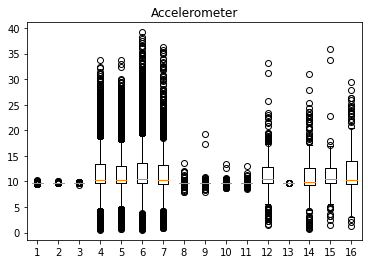

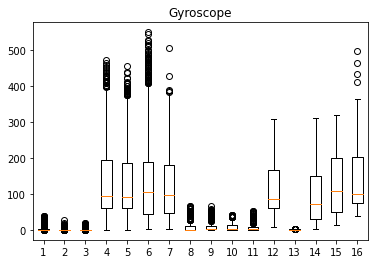

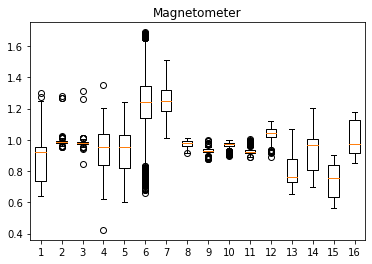

In [14]:
def boxplot(part):

    for k in part.keys():
        acc = [list()] * 16
        gyr = [list()] * 16
        mag = [list()] * 16

        i = part[k]
        for d in i:
            for a in range(1,17):
                pos = np.where(d[:,11] == a)[0]

                acc[a-1] = np.sqrt(d[pos,1]**2 + d[pos,2]**2 + d[pos,3]**2)

                gyr[a-1] = np.sqrt(d[pos,4]**2 + d[pos,5]**2 + d[pos,6]**2)

                mag[a-1] = np.sqrt(d[pos,7]**2 + d[pos,8]**2 + d[pos,9]**2)

        plt.boxplot(acc[0],widths=0.5)
        plt.title('Accelerometer')
        plt.savefig('Plots/'+str(k)+'-accelerometer.jpg')

        plt.show()

        plt.boxplot(gyr,widths=0.5)
        plt.title('Gyroscope')
        plt.savefig('Plots/'+str(k)+'-gyroscope.jpg')

        plt.show()

        plt.boxplot(mag,widths=0.5)
        plt.title('Magnetometer')
        plt.savefig('Plots/'+str(k)+'-magnetometer.jpg')

        plt.show()

boxplot(part)